In [1]:
import pandas as pd
import numpy as np
import os
import pickle

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import accuracy_score
from sklearn.metrics           import classification_report
from sklearn.metrics           import confusion_matrix
from sklearn.preprocessing     import LabelEncoder
from sklearn.preprocessing     import StandardScaler
from sklearn.tree              import ExtraTreeClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.naive_bayes       import GaussianNB

In [2]:
df = pd.read_csv('data/CICDDoS2019_Consolidated.csv')
df.shape

C:\Users\Brian\AppData\Local\Temp\ipykernel_5064\2680276053.py:1: DtypeWarning: Columns (1,4,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/CICDDoS2019_Consolidated.csv')


(488935, 89)

In [3]:
df.dropna(axis=0, inplace=True)
df.isnull().sum().sum()

0

In [4]:
df[' Label'].value_counts()

MSSQL      139587
Syn        114076
UDP         94715
NetBIOS     87933
LDAP        46774
Portmap      4444
BENIGN       1351
UDPLag         49
Name:  Label, dtype: int64

In [5]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', 

In [6]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df.columns

Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

In [7]:
df_x = df.drop([' Label', 'SimillarHTTP'], axis=1)
df_y = df[' Label']

df_y.unique()

array(['LDAP', 'NetBIOS', 'BENIGN', 'MSSQL', 'Portmap', 'Syn', 'UDP',
       'UDPLag'], dtype=object)

In [8]:
le = LabelEncoder()
df_y_trans = le.fit_transform(df_y)

le_fid = LabelEncoder()
le_fid.fit(df_x['Flow ID'])
df_x['Flow ID'] = le_fid.fit_transform(df_x['Flow ID'])

le_sip = LabelEncoder()
le_sip.fit(df_x[' Source IP'])
df_x[' Source IP'] = le_sip.fit_transform(df_x[' Source IP'])

le_dip = LabelEncoder()
le_dip.fit(df_x[' Destination IP'])
df_x[' Destination IP'] = le_dip.fit_transform(df_x[' Destination IP'])

le_t = LabelEncoder()
le_t.fit(df_x[' Timestamp'])
df_x[' Timestamp'] = le_t.fit_transform(df_x[' Timestamp'])

In [9]:
df_x

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
0,223278,27,520,146,22993,17,111250,1,2,0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,409387,27,755,146,3377,17,122409,1,2,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,412964,27,768,146,33027,17,130751,1,2,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,394443,27,700,146,60924,17,112057,2,2,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,316746,27,615,146,23073,17,135028,1,2,0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488930,440433,27,8673,146,33165,6,381200,1,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
488931,9570,27,11130,146,20694,6,376363,119,2,2,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
488932,483527,93,54686,226,53,17,373944,20807,2,2,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
488933,250498,27,54809,146,19261,6,382272,49,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [10]:
model = ExtraTreeClassifier(random_state=42)
model.fit(df_x, df_y_trans)

ExtraTreeClassifier(random_state=42)

<AxesSubplot: title={'center': 'STD Dataset Feature Selection using ExtraTreeClassifier'}>

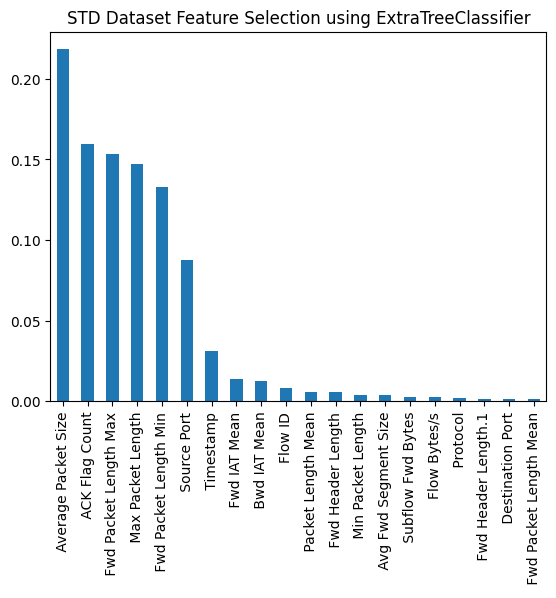

In [11]:
feature_importance_std = pd.Series(model.feature_importances_, index=df_x.columns)
feature_importance_std.nlargest(20).plot(kind='bar', title='STD Dataset Feature Selection using ExtraTreeClassifier')

In [12]:
df_top20_x = df_x[[' Average Packet Size',
                   ' ACK Flag Count',
                   ' Fwd Packet Length Max',
                   ' Max Packet Length',
                   ' Fwd Packet Length Min',
                   ' Source Port',
                   ' Timestamp',
                   ' Fwd IAT Mean',
                   ' Bwd IAT Mean',
                   'Flow ID',
                   ' Packet Length Mean',
                   ' Fwd Header Length',
                   ' Min Packet Length',
                   ' Avg Fwd Segment Size',
                   ' Subflow Fwd Bytes',
                   'Flow Bytes/s',
                   ' Protocol',
                   ' Fwd Header Length.1',
                   ' Destination Port',
                   ' Fwd Packet Length Mean']]

df_top20_x

,Average Packet Size,ACK Flag Count,Fwd Packet Length Max,Max Packet Length,Fwd Packet Length Min,Source Port,Timestamp,Fwd IAT Mean,Bwd IAT Mean,Flow ID,Packet Length Mean,Fwd Header Length,Min Packet Length,Avg Fwd Segment Size,Subflow Fwd Bytes,Flow Bytes/s,Protocol,Fwd Header Length.1,Destination Port,Fwd Packet Length Mean
0,2208.0,0,1472.0,1472.0,1472.0,520,111250,1.0,0.0,223278,1472.0,64,1472.0,1472.0,2944,2944000000.0,17,64,22993,1472.0
1,2208.0,0,1472.0,1472.0,1472.0,755,122409,1.0,0.0,409387,1472.0,0,1472.0,1472.0,2944,2944000000.0,17,0,3377,1472.0
2,2208.0,0,1472.0,1472.0,1472.0,768,130751,1.0,0.0,412964,1472.0,0,1472.0,1472.0,2944,2944000000.0,17,0,33027,1472.0
3,2208.0,0,1472.0,1472.0,1472.0,700,112057,2.0,0.0,394443,1472.0,0,1472.0,1472.0,2944,1472000000.0,17,0,60924,1472.0
4,2208.0,0,1472.0,1472.0,1472.0,615,135028,1.0,0.0,316746,1472.0,16,1472.0,1472.0,2944,2944000000.0,17,16,23073,1472.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488930,9.0,1,6.0,6.0,6.0,8673,381200,1.0,0.0,440433,6.0,40,6.0,6.0,12,12000000.0,6,40,33165,6.0
488931,7.5,1,6.0,6.0,6.0,11130,376363,1.0,1.0,9570,6.0,40,6.0,6.0,12,201680.672269,6,40,20694,6.0
488932,62.75,0,31.0,79.0,31.0,54686,373944,3.0,3.0,483527,50.2,40,31.0,31.0,62,10573.364733,17,40,53,31.0
488933,9.0,1,6.0,6.0,6.0,54809,382272,49.0,0.0,250498,6.0,40,6.0,6.0,12,244897.959184,6,40,19261,6.0


In [13]:
df_y_trans

array([1, 1, 1, ..., 0, 5, 5])

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df_top20_x,
                                                    df_y_trans,
                                                    test_size=0.3,
                                                    random_state=42)

In [15]:
x_train.shape

(342250, 20)

In [16]:
y_train.shape

(342250,)

In [17]:
x_test.shape

(146679, 20)

In [18]:
y_test.shape

(146679,)

In [19]:
ss = StandardScaler()
x_train_std = ss.fit_transform(x_train)
x_test_std = ss.fit_transform(x_test)

In [20]:
dt = DecisionTreeClassifier()
dt.fit(x_train_std, y_train)

DecisionTreeClassifier()

In [21]:
dt_y_prediction = dt.predict(x_test_std)
print('Classification Report for DT: \n', classification_report(le.inverse_transform(y_test), le.inverse_transform(dt_y_prediction)))

Classification Report for DT: 
               precision    recall  f1-score   support

      BENIGN       1.00      0.83      0.91       393
        LDAP       0.98      0.98      0.98     14052
       MSSQL       0.99      1.00      1.00     41787
     NetBIOS       0.99      0.99      0.99     26541
     Portmap       0.98      0.84      0.90      1357
         Syn       1.00      1.00      1.00     34032
         UDP       0.99      0.99      0.99     28504
      UDPLag       0.05      0.77      0.10        13

    accuracy                           0.99    146679
   macro avg       0.87      0.92      0.86    146679
weighted avg       0.99      0.99      0.99    146679



In [22]:
dt_confusion_matrix = confusion_matrix(y_test, dt_y_prediction)
print('Decision Tree Confusion Matrix: \n', dt_confusion_matrix)

Decision Tree Confusion Matrix: 
 [[  325     2     2     5    19    37     0     3]
 [    0 13835   217     0     0     0     0     0]
 [    0     0 41595     0     0     0   192     0]
 [    0   218     0 26323     0     0     0     0]
 [    0     0     0   221  1136     0     0     0]
 [    0     0     0     0     0 34032     0     0]
 [    0     0     1     0     0     0 28326   177]
 [    0     0     0     0     0     1     2    10]]


In [23]:
ac_score_dt = accuracy_score(y_test, dt_y_prediction)
print("Accuracy Score for DT: \n", ac_score_dt * 100)

Accuracy Score for DT: 
 99.25210834543459


In [24]:
with open('dt_model.pkl', 'wb') as file:
    pickle.dump(dt, file)

In [25]:
nb = GaussianNB()
nb.fit(x_train_std, y_train)
nb_y_prediction = nb.predict(x_test_std)
nb_y_prediction.shape

(146679,)

In [26]:
print('Classification Report for NB: \n', classification_report(le.inverse_transform(y_test), le.inverse_transform(nb_y_prediction), zero_division=1))

Classification Report for NB: 
               precision    recall  f1-score   support

      BENIGN       0.01      1.00      0.02       393
        LDAP       1.00      0.00      0.00     14052
       MSSQL       0.49      1.00      0.66     41787
     NetBIOS       0.95      0.99      0.97     26541
     Portmap       1.00      0.00      0.00      1357
         Syn       1.00      0.00      0.00     34032
         UDP       0.00      0.00      0.00     28504
      UDPLag       1.00      0.00      0.00        13

    accuracy                           0.47    146679
   macro avg       0.68      0.37      0.21    146679
weighted avg       0.65      0.47      0.36    146679



In [27]:
nb_confusion_matrix = confusion_matrix(y_test, nb_y_prediction)
print('Naive Bayes Confusion Matrix: \n', nb_confusion_matrix)

Naive Bayes Confusion Matrix: 
 [[  392     0     1     0     0     0     0     0]
 [    3     0 14049     0     0     0     0     0]
 [    8     0 41778     0     0     0     1     0]
 [   28     0   246 26267     0     0     0     0]
 [    4     0    17  1336     0     0     0     0]
 [34002     0    30     0     0     0     0     0]
 [   22     0 28482     0     0     0     0     0]
 [    3     0    10     0     0     0     0     0]]


In [28]:
ac_score_nb = accuracy_score(y_test, nb_y_prediction)
print('Accuracy Score for NB: \n', ac_score_nb * 100)

Accuracy Score for NB: 
 46.65766742342121


In [29]:
with open('nb_model.pkl', 'wb') as file:
    pickle.dump(nb, file)

In [30]:
lr = LogisticRegression(max_iter=10000)
lr.fit(x_train_std, y_train)

LogisticRegression(max_iter=10000)

In [31]:
lr_y_prediction = lr.predict(x_test_std)
print('Classification Report for LR: \n', classification_report(le.inverse_transform(y_test), le.inverse_transform(lr_y_prediction), zero_division=1))

Classification Report for LR: 
               precision    recall  f1-score   support

      BENIGN       0.94      0.93      0.93       393
        LDAP       1.00      1.00      1.00     14052
       MSSQL       1.00      1.00      1.00     41787
     NetBIOS       0.98      1.00      0.99     26541
     Portmap       0.98      0.63      0.77      1357
         Syn       1.00      1.00      1.00     34032
         UDP       1.00      1.00      1.00     28504
      UDPLag       1.00      0.00      0.00        13

    accuracy                           0.99    146679
   macro avg       0.99      0.82      0.84    146679
weighted avg       0.99      0.99      0.99    146679



In [32]:
ac_score_lr = accuracy_score(y_test, lr_y_prediction)
print('Accuracy Score for LR: \n', ac_score_lr * 100)

Accuracy Score for LR: 
 99.4157309498974


In [33]:
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(lr, file)